In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from net import Net
from dataset import get_caption_dataset
%matplotlib inline

In [2]:
batch_size = 8
image_size = 224
hidden_dim = 512
num_layers = 1

data_root = "./data"
ckpt_path = "./checkpoint/caption_200.pth"

In [3]:
# to initialize vocab
_, _, TEXT = get_caption_dataset(
    train=True,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size,
    text_field=True)

loader, dataset = get_caption_dataset(
    train=False,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(TEXT, hidden_dim, num_layers).to(device)

# load pre-trained model
state_dict = torch.load(ckpt_path)
net.load_state_dict(state_dict)

In [5]:
net.eval()
cap_repr, pred_repr = list(), list()
with torch.no_grad():
    for inputs in loader:
        image   = inputs[0].to(device)
        caption = inputs[1]
        
        preds = net.sample(image)
    
        for pred, cap in zip(preds, caption):
            cap_sent, cap_words = dataset.indices_to_string(cap, True)
            pred_sent, pred_words = dataset.indices_to_string(pred, True)
            
            cap_repr.append(cap_sent)
            pred_repr.append(pred_sent)
            
        break # run only first batch

In [6]:
def inverse_transform(image):
    transform = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    image = image.clone()
    image = transform(image).mul(255).clamp_(0, 255)
    
    return image.byte().permute(1, 2, 0).cpu().numpy()

def pretty_print(string, width=100):
    new_string = ""
    for i in range(0, len(string), width):
        new_string += string[i:i+width]
        if i+width < len(string):
            new_string += "\n"
    return new_string

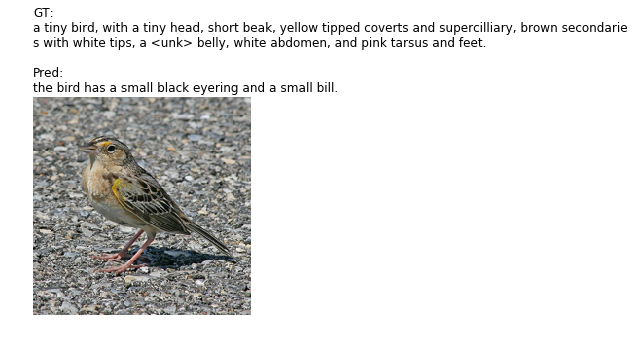

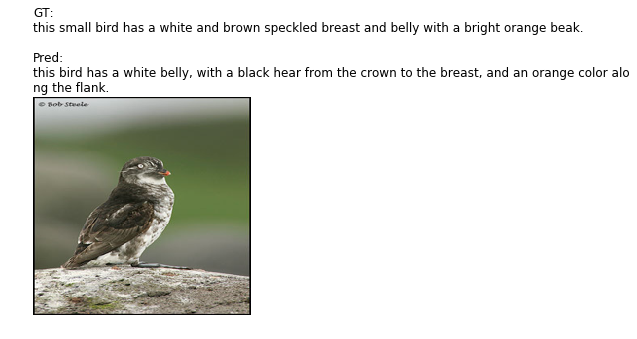

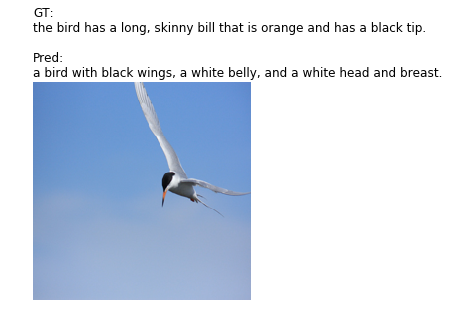

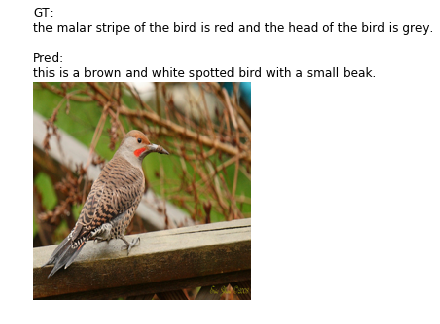

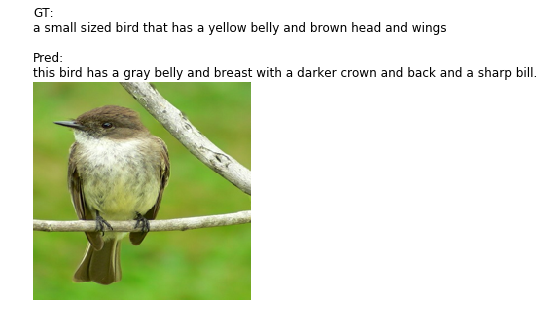

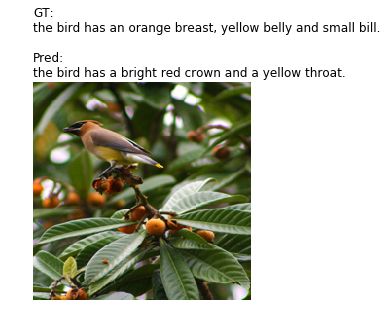

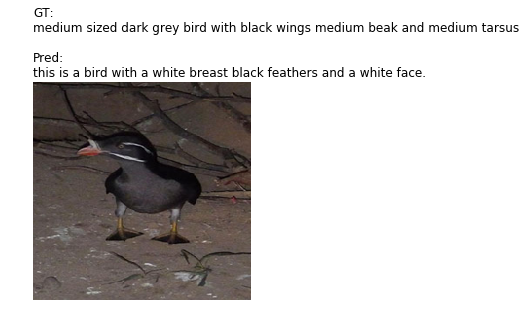

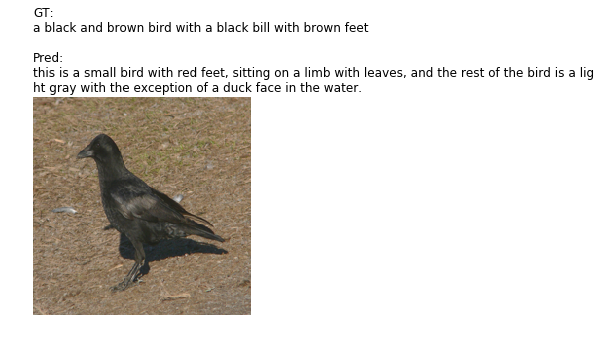

In [7]:
# visualize first batch
for i, (im, cap, pred) in enumerate(zip(image, cap_repr, pred_repr)):
    im = inverse_transform(im)
    
    cap = pretty_print(cap)
    pred = pretty_print(pred)
    
    sentence = "GT:\n{}\n\nPred:\n{}".format(cap, pred)
    
    fig = plt.figure()
    plt.title(sentence, loc="left")
    plt.imshow(im)
    plt.axis("off")